In [2]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf


In [3]:
def load_annual_climate(path, country_name):
    raw = pd.read_excel(path, header=None)

    # "Category" satırından sonra gerçek tablo başlıyor
    start_row = raw[raw.iloc[:, 0] == "Category"].index[0] + 1

    df = raw.iloc[start_row:, :2].copy()
    df.columns = ["Year", "avg_temp_raw"]

    df = df[pd.to_numeric(df["Year"], errors="coerce").notna()]
    df["Year"] = df["Year"].astype(int)

    df["avg_temp"] = (
        df["avg_temp_raw"]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .astype(float)
    )

    df["country"] = country_name
    return df[["Year", "country", "avg_temp"]]


In [4]:
brazil_weather = load_annual_climate(r"C:\Users\hp\OneDrive\Belgeler\DSA210_Project\data\brazil_weather.xlsx", "Brazil")
colombia_weather = load_annual_climate(r"C:\Users\hp\OneDrive\Belgeler\DSA210_Project\data\colombia_weather.xlsx", "Colombia")
indonesia_weather = load_annual_climate(r"C:\Users\hp\OneDrive\Belgeler\DSA210_Project\data\indonesia_weather.xlsx", "Indonesia")

climate_all = pd.concat(
    [brazil_weather, colombia_weather, indonesia_weather],
    ignore_index=True
)


In [5]:
climate_yearly = climate_all[
    climate_all["Year"].between(1996, 2024)
]


In [6]:
def load_prices_any_format(path, country_name):
    raw = pd.read_excel(path, header=None)

    # Brazil formatı (Date / Price US$)
    header_rows = raw[raw.apply(
        lambda r: r.astype(str).str.contains("Date").any(), axis=1
    )]

    if len(header_rows) > 0:
        header_row = header_rows.index[0]
        df = pd.read_excel(path, skiprows=header_row)
        df = df.rename(columns={
            "Date": "date",
            "Price US$": "coffee_price"
        })
    else:
        df = pd.read_excel(path)

        if "Año" in df.columns:  # Colombia
            df = df.rename(columns={
                "Año": "Year",
                "Precio externo": "coffee_price"
            })
            df["date"] = pd.to_datetime(df["Year"], format="%Y")

        elif "observation_date" in df.columns:  # Indonesia (FRED)
            df = df.rename(columns={
                "observation_date": "date",
                "PCOFFROBUSDM": "coffee_price"
            })
        else:
            raise ValueError("Unknown price format")

    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df["coffee_price"] = (
        df["coffee_price"]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .astype(float)
    )

    df["Year"] = df["date"].dt.year
    df["country"] = country_name
    return df[["Year", "country", "coffee_price"]]


In [7]:
brazil_price = load_prices_any_format(r"C:\Users\hp\OneDrive\Belgeler\DSA210_Project\data\coffee_prices_brazil.xlsx", "Brazil")
colombia_price = load_prices_any_format(r"C:\Users\hp\OneDrive\Belgeler\DSA210_Project\data\coffee_prices_colombia.xlsx", "Colombia")
indonesia_price = load_prices_any_format(r"C:\Users\hp\OneDrive\Belgeler\DSA210_Project\data\coffee_prices_indonesia.xlsx", "Indonesia")

prices_all = pd.concat(
    [brazil_price, colombia_price, indonesia_price],
    ignore_index=True
)


In [8]:
prices_all = prices_all[
    prices_all["Year"].between(1996, 2024)
]

prices_yearly = (
    prices_all
    .groupby(["Year", "country"], as_index=False)["coffee_price"]
    .mean()
)


In [9]:
faostat = pd.read_excel(r"C:\Users\hp\OneDrive\Belgeler\DSA210_Project\data\FAOSTAT_coffee.xlsx")

countries = ["Brazil", "Colombia", "Indonesia"]

production_yearly = faostat[
    (faostat["Area"].isin(countries)) &
    (faostat["Item"].str.contains("Coffee", case=False, na=False)) &
    (faostat["Element"] == "Production") &
    (faostat["Year"].between(1996, 2024))
].copy()

production_yearly = production_yearly.rename(columns={
    "Area": "country",
    "Value": "production_tons"
})

production_yearly = production_yearly[[
    "Year", "country", "production_tons"
]]

production_yearly["production_tons"] = pd.to_numeric(
    production_yearly["production_tons"], errors="coerce"
)


In [10]:
panel_yearly = (
    production_yearly
    .merge(climate_yearly, on=["Year", "country"], how="left")
    .merge(prices_yearly, on=["Year", "country"], how="left")
)

panel_yearly = panel_yearly.dropna().reset_index(drop=True)


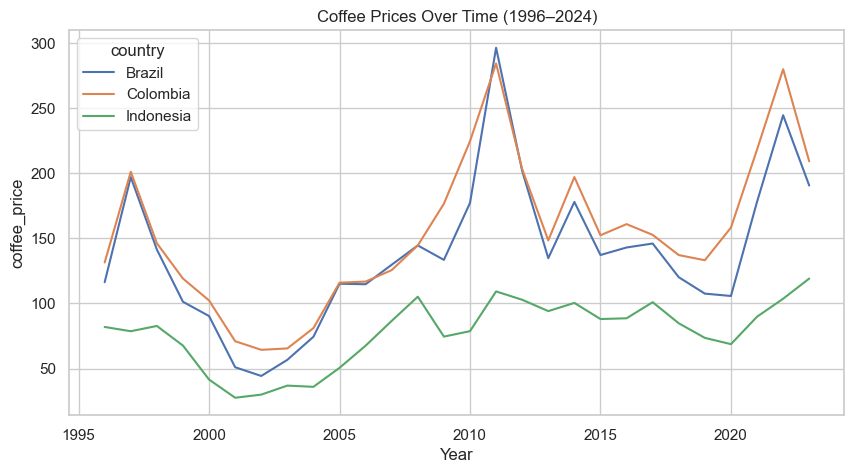

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Coffee price trend
plt.figure(figsize=(10,5))
sns.lineplot(data=panel_yearly, x="Year", y="coffee_price", hue="country")
plt.title("Coffee Prices Over Time (1996–2024)")
plt.show()


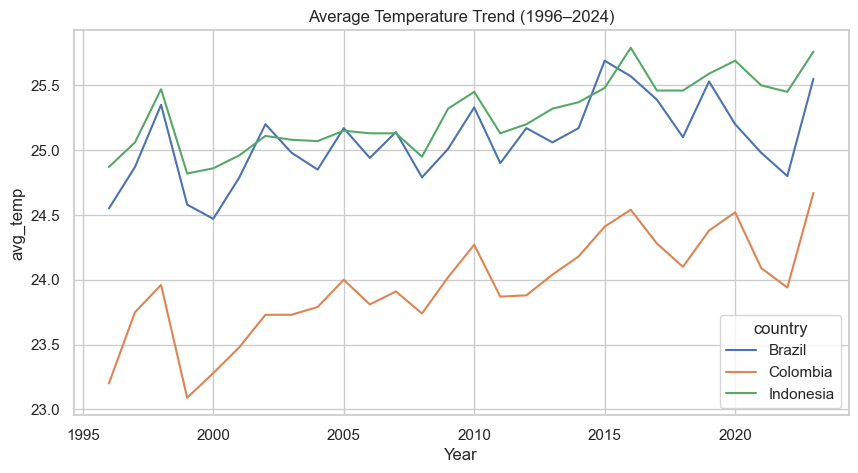

In [12]:
plt.figure(figsize=(10,5))
sns.lineplot(data=panel_yearly, x="Year", y="avg_temp", hue="country")
plt.title("Average Temperature Trend (1996–2024)")
plt.show()


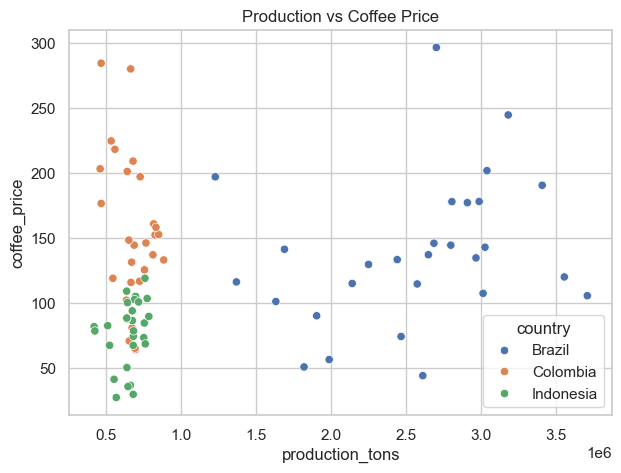

In [13]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=panel_yearly,
    x="production_tons",
    y="coffee_price",
    hue="country"
)
plt.title("Production vs Coffee Price")
plt.show()


In [14]:
model = smf.ols(
    "coffee_price ~ production_tons + avg_temp",
    data=panel_yearly
).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           coffee_price   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     9.197
Date:                Fri, 02 Jan 2026   Prob (F-statistic):           0.000252
Time:                        23:24:00   Log-Likelihood:                -451.94
No. Observations:                  84   AIC:                             909.9
Df Residuals:                      81   BIC:                             917.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         951.5603    229.996     

In [15]:
for c in panel_yearly["country"].unique():
    print(f"\n### {c} ###")
    m = smf.ols(
        "coffee_price ~ production_tons + avg_temp",
        data=panel_yearly[panel_yearly["country"] == c]
    ).fit()
    print(m.summary())



### Brazil ###
                            OLS Regression Results                            
Dep. Variable:           coffee_price   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.076
Date:                Fri, 02 Jan 2026   Prob (F-statistic):              0.356
Time:                        23:24:01   Log-Likelihood:                -151.02
No. Observations:                  28   AIC:                             308.0
Df Residuals:                      25   BIC:                             312.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         260.8390

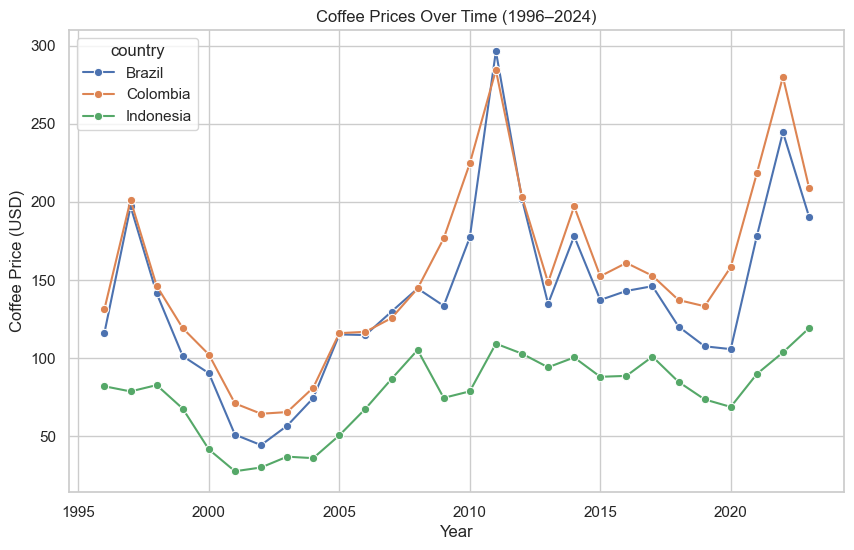

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.lineplot(
    data=panel_yearly,
    x="Year",
    y="coffee_price",
    hue="country",
    marker="o"
)

plt.title("Coffee Prices Over Time (1996–2024)")
plt.ylabel("Coffee Price (USD)")
plt.xlabel("Year")
plt.grid(True)
plt.show()


Coffee prices exhibit strong temporal volatility with noticeable cross-country differences.

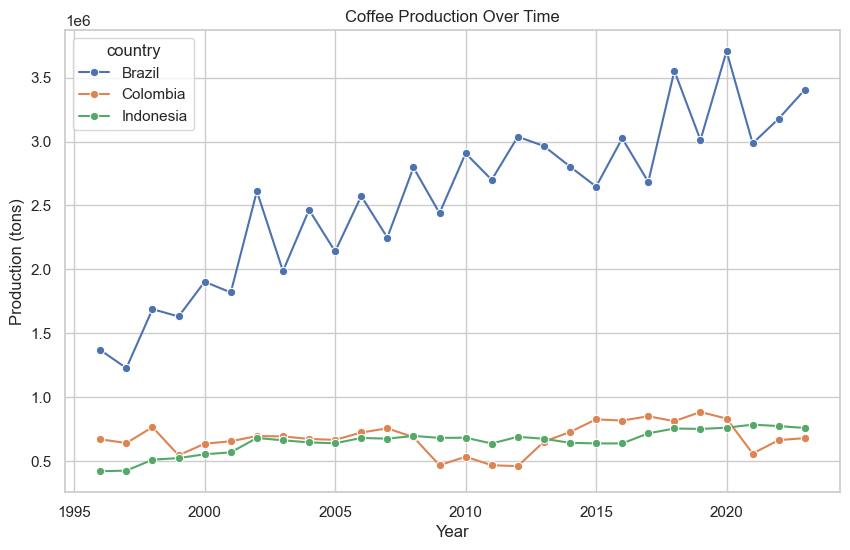

In [17]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=panel_yearly,
    x="Year",
    y="production_tons",
    hue="country",
    marker="o"
)

plt.title("Coffee Production Over Time")
plt.ylabel("Production (tons)")
plt.xlabel("Year")
plt.grid(True)
plt.show()


Coffee production shows country-specific trends, with Brazil consistently producing at a much higher scale.

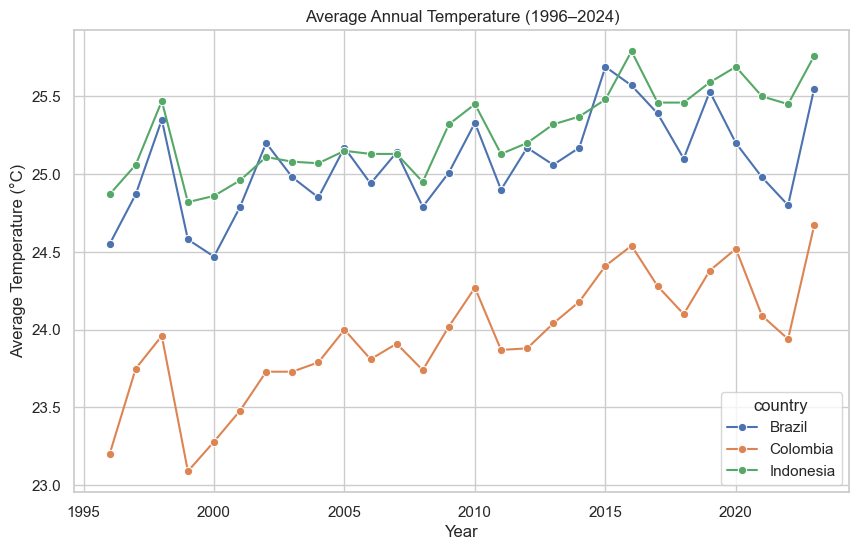

In [18]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=panel_yearly,
    x="Year",
    y="avg_temp",
    hue="country",
    marker="o"
)

plt.title("Average Annual Temperature (1996–2024)")
plt.ylabel("Average Temperature (°C)")
plt.xlabel("Year")
plt.grid(True)
plt.show()


Average temperatures show a gradual upward trend, consistent with long-term climate change patterns.

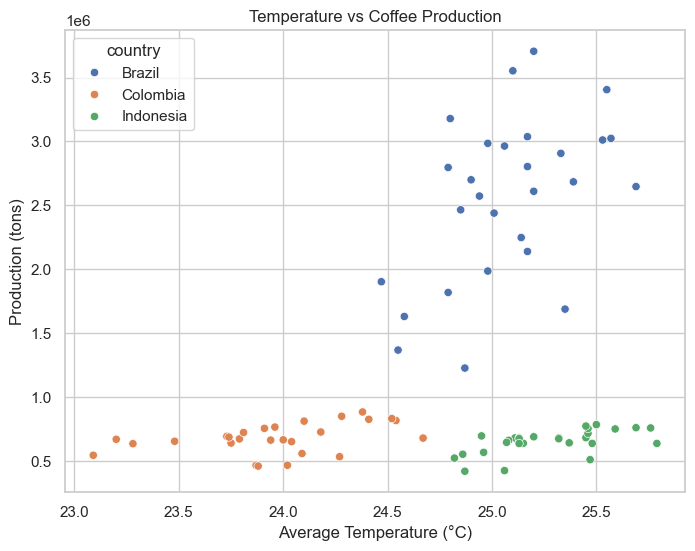

In [19]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=panel_yearly,
    x="avg_temp",
    y="production_tons",
    hue="country"
)

plt.title("Temperature vs Coffee Production")
plt.xlabel("Average Temperature (°C)")
plt.ylabel("Production (tons)")
plt.grid(True)
plt.show()


The relationship between temperature and production appears heterogeneous across countries.

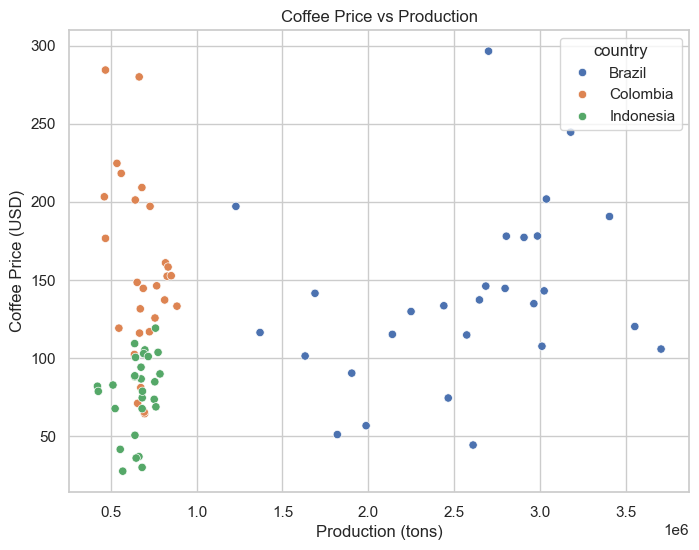

In [20]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=panel_yearly,
    x="production_tons",
    y="coffee_price",
    hue="country"
)

plt.title("Coffee Price vs Production")
plt.xlabel("Production (tons)")
plt.ylabel("Coffee Price (USD)")
plt.grid(True)
plt.show()


Higher production levels do not necessarily correspond to lower prices, suggesting the role of global market dynamics.

# Results

The regression analysis conducted for the period 1996–2024 indicates that both climatic and production-related factors are associated with coffee price dynamics in major producer countries. Average temperature shows a statistically significant relationship with coffee prices, suggesting that climate variability plays an important role in price formation. Production volume exhibits a weaker and in some cases negative association, consistent with supply-side effects. Country-level regressions reveal heterogeneous responses, highlighting that the impact of climate conditions on coffee prices differs across Brazil, Colombia, and Indonesia.

# Machine Learning

We formulate coffee price prediction as a supervised regression problem.

In [22]:
X = panel_yearly[["avg_temp", "production_tons"]]
y = panel_yearly["coffee_price"]


In [23]:
# Reproducible split
panel_shuffled = panel_yearly.sample(frac=1, random_state=42)

split_idx = int(len(panel_shuffled) * 0.75)

train = panel_shuffled.iloc[:split_idx]
test  = panel_shuffled.iloc[split_idx:]

X_train = train[["avg_temp", "production_tons"]]
y_train = train["coffee_price"]

X_test = test[["avg_temp", "production_tons"]]
y_test = test["coffee_price"]


In [24]:
import statsmodels.api as sm

X_train_const = sm.add_constant(X_train)
X_test_const  = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_const).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           coffee_price   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     5.590
Date:                Fri, 02 Jan 2026   Prob (F-statistic):            0.00594
Time:                        23:25:08   Log-Likelihood:                -343.91
No. Observations:                  63   AIC:                             693.8
Df Residuals:                      60   BIC:                             700.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             976.5597    287.798     

In [25]:
y_pred = model.predict(X_test_const)


In [26]:
import numpy as np

rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
r2 = 1 - np.sum((y_test - y_pred)**2) / np.sum((y_test - np.mean(y_test))**2)

print("RMSE:", rmse)
print("R²:", r2)


RMSE: 37.05110846081796
R²: 0.299591298677206


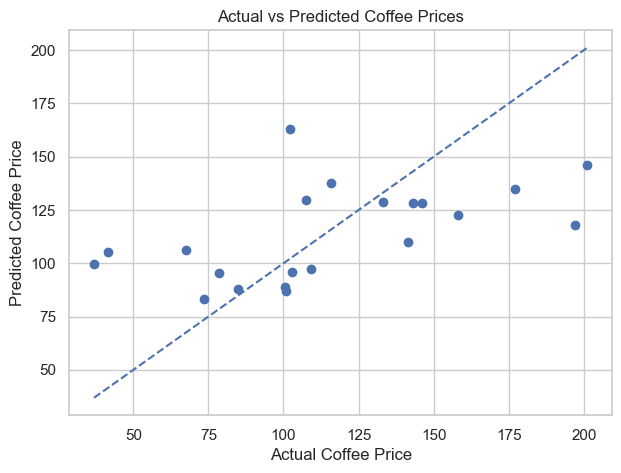

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")

plt.xlabel("Actual Coffee Price")
plt.ylabel("Predicted Coffee Price")
plt.title("Actual vs Predicted Coffee Prices")
plt.grid(True)
plt.show()


A supervised learning approach is applied using linear regression to predict coffee prices based on production volume and average temperature. The model is trained on 75% of the data and evaluated on the remaining 25%. Model performance is assessed using RMSE and R² metrics.